In [1]:
import visualize_background as vb
import visualize_foreground as vf
import visualize_rhs as vr
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import h5py
import numpy as np

/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
def central_y(var, dy):
        #rolling the variables and making sure top and bottom boundaries are removed
        positive_var = np.roll(var, -1, axis=1)
        negative_var = np.roll(var, 1, axis=1)

        #returning central scheme
        return (positive_var-negative_var)/(2*dy)


def central_z(var, dz):
    #rolling the variables and making sure top and bottom boundaries are removed
    positive_var = np.roll(var, -1, axis=0)
    negative_var = np.roll(var, 1, axis=0)

    #returning central scheme
    return (positive_var-negative_var)/(2*dz)

def upwind_y(var, v, dy):
    #rolling the variables and making sure top and bottom boundaries are removed
    positive_var = np.roll(var, -1, axis=1)
    negative_var = np.roll(var, 1, axis=1)

    #calculating upwind scheme for positive velocity
    upwind = (var - negative_var)/dy

    #checking if velocity<0 at any point in the grid
    x,y = np.where(v<0)

    #checking if any negative values occured and using the upwind scheme for negative velocity
    #at the points of negative velocity values
    if len(x) != 0:
        for index in range(len(x)):
            x_index = x[index]
            y_index = y[index]
            upwind[x_index,y_index] = (positive_var[x_index,y_index] - var[x_index,y_index])/dy
    return upwind


def upwind_y_second_order(var, v, dy):
    #rolling the variables and making sure top and bottom boundaries are removed
    positive_var = np.roll(var, -1, axis=1)
    positive2_var = np.roll(var, -2, axis=1)
    negative_var = np.roll(var, 1, axis=1)
    negative2_var = np.roll(var, 2, axis=1)

    #calculating upwind scheme for positive velocity
    upwind = (3*var - 4*negative_var+negative2_var)/dy

    #checking if velocity<0 at any point in the grid
    x,y = np.where(v<0)

    #checking if any negative values occured and using the upwind scheme for negative velocity
    #at the points of negative velocity values
    if len(x) != 0:
        for index in range(len(x)):
            x_index = x[index]
            y_index = y[index]
            upwind[x_index,y_index] = (-3*var[x_index,y_index] + 4*positive_var[x_index,y_index] - positive2_var[x_index,y_index])/dy #u<0 scheme
            
    return upwind

def upwind_z(var, v, dz):
    #rolling the variables and making sure top and bottom boundaries are removed
    positive_var = np.roll(var, -1, axis=0)
    negative_var = np.roll(var, 1, axis=0)

    #calculating upwind scheme for positive velocity
    upwind = (var - negative_var)/dz

    #checking if velocity<0 at any point in the grid
    x,y = np.where(v<0)

    #checking if any negative values occured and using the upwind scheme for negative velocity
    #at the points of negative velocity values
    if len(x) != 0:
        for index in range(len(x)):
            x_index = x[index]
            y_index = y[index]
            upwind[x_index,y_index] = (positive_var[x_index,y_index] - var[x_index,y_index])/dz

    return upwind

def upwind_z_second_order(var, v, dz):
    #rolling the variables and making sure top and bottom boundaries are removed
    positive_var = np.roll(var, -1, axis=0)
    positive2_var = np.roll(var, -2, axis=0)
    negative_var = np.roll(var, 1, axis=0)
    negative2_var = np.roll(var, 2, axis=0)

    #calculating upwind scheme for positive velocity
    upwind = (3*var - 4*negative_var+negative2_var)/dz

    #checking if velocity<0 at any point in the grid
    x,y = np.where(v<0)

    #checking if any negative values occured and using the upwind scheme for negative velocity
    #at the points of negative velocity values
    if len(x) != 0:
        for index in range(len(x)):
            x_index = x[index]
            y_index = y[index]
            upwind[x_index,y_index] = (-3*var[x_index,y_index] + 4*positive_var[x_index,y_index] - positive2_var[x_index,y_index])/dz

    return upwind

In [3]:
def rhs_entropy_python(snap, folder, order=1):
    n_procs = vf.read_mpi_info(folder+"mpi_info.h5")
    fg_vars, info = vf.read_fg_mpi(snap, n_procs, folder)

    bg_vars, _ = vf.read_bg_mpi(n_procs, folder)
    nz_ghost = info['nz_ghost']

    vy = fg_vars["vy"][nz_ghost:-nz_ghost]
    vz = fg_vars["vz"][nz_ghost:-nz_ghost]
    s1 = fg_vars["s1"][nz_ghost:-nz_ghost]
    grad_s0 = bg_vars["grad_s0"][nz_ghost:-nz_ghost]

    dy = info["dy"]
    dz = info["dz"]

    if order==1:
        ds1_dy = upwind_y(s1, vy, dy)
        ds1_dz = upwind_z(s1, vz, dz)
    elif order==2:
        ds1_dy = upwind_y_second_order(s1, vy, dy)
        ds1_dz = upwind_z_second_order(s1, vz, dz)

    rhs = - (vy*ds1_dy + vz*ds1_dz + vz*grad_s0[:,np.newaxis])

    return rhs, ds1_dy, ds1_dz

def rhs_momentum_y(snap, folder, order=1):
    n_procs = vf.read_mpi_info(folder+"mpi_info.h5")
    fg_vars, info = vf.read_fg_mpi(snap, n_procs, folder)

    bg_vars, _ = vf.read_bg_mpi(n_procs, folder)
    nz_ghost = info['nz_ghost']

    vy = fg_vars["vy"][nz_ghost:-nz_ghost]
    vz = fg_vars["vz"][nz_ghost:-nz_ghost]
    p1 = fg_vars["p1"][nz_ghost:-nz_ghost]
    rho0 = bg_vars["rho0"][nz_ghost:-nz_ghost]

    dy = info["dy"]
    dz = info["dz"]

    dp1_dy = central_y(p1, dy)

    if order==1:
        dvy_dy = upwind_y(vy, vy, dy)
        dvy_dz = upwind_z(vy, vz, dz)
    elif order==2:
        dvy_dy = upwind_y_second_order(vy, vy, dy)
        dvy_dz = upwind_z_second_order(vy, vz, dz)

    rhs = - (vy*dvy_dy + vz*dvy_dz + dp1_dy/rho0[:,np.newaxis])

    return rhs, dvy_dy, dvy_dz

def rhs_momentum_z(snap, folder, order=1):
    n_procs = vf.read_mpi_info(folder+"mpi_info.h5")
    fg_vars, info = vf.read_fg_mpi(snap, n_procs, folder)

    bg_vars, _ = vf.read_bg_mpi(n_procs, folder)
    nz_ghost = info['nz_ghost']

    vy = fg_vars["vy"][nz_ghost:-nz_ghost]
    vz = fg_vars["vz"][nz_ghost:-nz_ghost]
    p1 = fg_vars["p1"][nz_ghost:-nz_ghost]
    rho1 = fg_vars["rho1"][nz_ghost:-nz_ghost]
    rho0 = bg_vars["rho0"][nz_ghost:-nz_ghost]
    g = bg_vars["g"][nz_ghost:-nz_ghost]

    dy = info["dy"]
    dz = info["dz"]

    dp1_dz = central_z(p1, dz)

    if order==1:
        dvz_dy = upwind_y(vz, vy, dy)
        dvz_dz = upwind_z(vz, vz, dz)
    elif order==2:
        dvz_dy = upwind_y_second_order(vz, vy, dy)
        dvz_dz = upwind_z_second_order(vz, vz, dz)

    rhs = - (vy*dvz_dy + vz*dvz_dz + dp1_dz/rho0[:,np.newaxis] + rho1/rho0[:,np.newaxis]*g[:,np.newaxis])

    return rhs, dvz_dy, dvz_dz


def get_rhs_python(snap, folder, order=1):
    variables = {}

    variables['rhs_s1'], variables['ds1_dy_vy'], variables['ds1_dz_vz'] = rhs_entropy_python(snap, folder, order)
    variables['rhs_vy'], variables['dvy_dy_vy'], variables['dvy_dz_vz'] = rhs_momentum_y(snap, folder, order)
    variables['rhs_vz'], variables['dvz_dy_vy'], variables['dvz_dz_vz'] = rhs_momentum_z(snap, folder, order)
    return variables

In [16]:
DATA_FOLDER = "/mn/stornext/d10/data/tabjone/data/"
RUN_NAME = "new_test11/"

snap = 100

folder = DATA_FOLDER+RUN_NAME
n_procs = vf.read_mpi_info(folder+"mpi_info.h5")
variables_c = vr.read_rhs_mpi(snap, n_procs, folder+"rhs/")
variables_python = get_rhs_python(snap, folder, order=2)
fg_vars, info = vf.read_fg_mpi(snap, n_procs, folder)
bg_vars, _ = vf.read_bg_mpi(n_procs, folder)

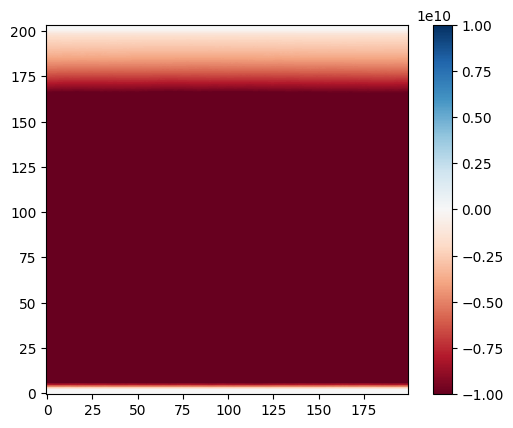

In [18]:
#vmin = -1e-9
#vmin = -0.002
vmin = -1e10
vmax = 1e10


plt.imshow(fg_vars['p1'], origin='lower', cmap="RdBu", vmin=vmin, vmax=vmax)
plt.colorbar()

In [16]:
variables_python.keys()

dict_keys(['rhs_s1', 'ds1_dy_vy', 'ds1_dz_vz', 'rhs_vy', 'dvy_dy_vy', 'dvy_dz_vz', 'rhs_vz', 'dvz_dy_vy', 'dvz_dz_vz'])

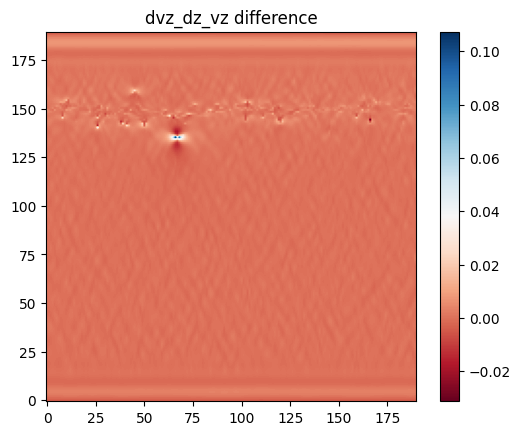

In [26]:
var = list(variables_python.keys())[8]

fig, ax = plt.subplots()
im = ax.imshow(variables_c[var][5:-5,5:-5] - variables_python[var][5:-5,5:-5], origin="lower", cmap="RdBu")
plt.title(var+" difference")
plt.colorbar(im)

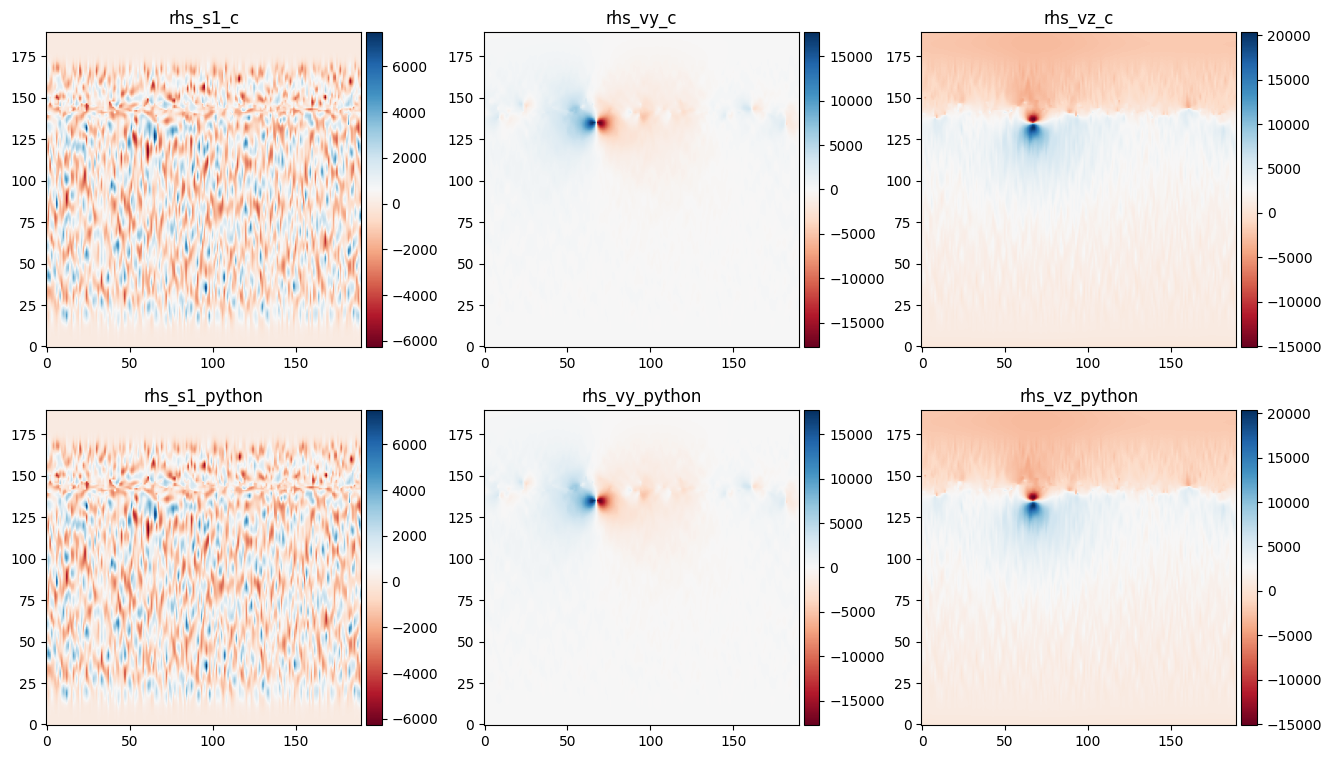

In [71]:
fig, ax = plt.subplots(2,3, figsize=(16,9))

im00 = ax[0][0].imshow(variables_c["rhs_s1"][5:-5, 5:-5], origin="lower", cmap="RdBu")
ax[0][0].set_title("rhs_s1_c")
divider = make_axes_locatable(ax[0][0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im00, cax=cax)

im01 = ax[0][1].imshow(variables_c["rhs_vy"][5:-5, 5:-5], origin="lower", cmap="RdBu")
ax[0][1].set_title("rhs_vy_c")
divider = make_axes_locatable(ax[0][1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im01, cax=cax)

im02 = ax[0][2].imshow(variables_c["rhs_vz"][5:-5, 5:-5], origin="lower", cmap="RdBu")
ax[0][2].set_title("rhs_vz_c")
divider = make_axes_locatable(ax[0][2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im02, cax=cax)

im10 = ax[1][0].imshow(variables_python["rhs_s1"][5:-5, 5:-5], origin="lower", cmap="RdBu")
ax[1][0].set_title("rhs_s1_python")
divider = make_axes_locatable(ax[1][0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im10, cax=cax)

im11 = ax[1][1].imshow(variables_python["rhs_vy"][5:-5, 5:-5], origin="lower", cmap="RdBu")
ax[1][1].set_title("rhs_vy_python")
divider = make_axes_locatable(ax[1][1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im11, cax=cax)

im12 = ax[1][2].imshow(variables_python["rhs_vz"][5:-5, 5:-5], origin="lower", cmap="RdBu")
ax[1][2].set_title("rhs_vz_python")
divider = make_axes_locatable(ax[1][2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im12, cax=cax)

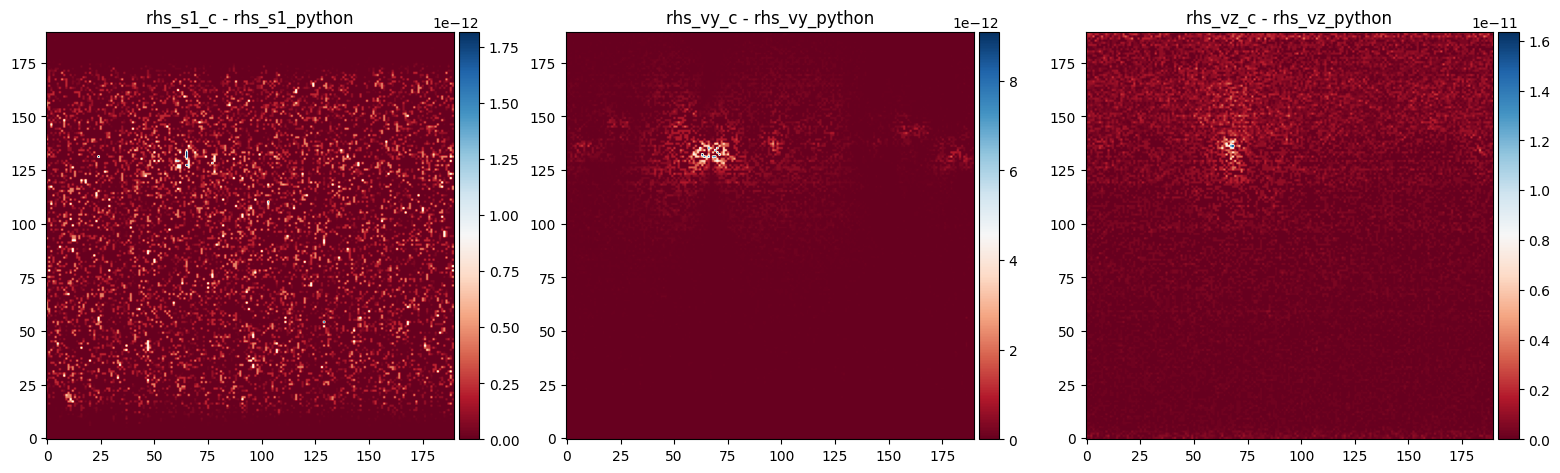

In [72]:
#difference plot
fig, ax = plt.subplots(1,3, figsize=(19,9))

im0 = ax[0].imshow(np.abs(variables_c["rhs_s1"][5:-5, 5:-5]-variables_python["rhs_s1"][5:-5, 5:-5]), origin="lower", cmap="RdBu")
ax[0].set_title("rhs_s1_c - rhs_s1_python")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im0, cax=cax)

im1 = ax[1].imshow(np.abs(variables_c["rhs_vy"][5:-5, 5:-5]-variables_python["rhs_vy"][5:-5, 5:-5]), origin="lower", cmap="RdBu")
ax[1].set_title("rhs_vy_c - rhs_vy_python")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax)

im2 = ax[2].imshow(np.abs(variables_c["rhs_vz"][5:-5, 5:-5]-variables_python["rhs_vz"][5:-5, 5:-5]), origin="lower", cmap="RdBu")
ax[2].set_title("rhs_vz_c - rhs_vz_python")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)